# Tutorial 1: Identify cancerous domains in single ST dataset

We use STANDS to identify carcinogenic domains in single ST dataset. Specifically, this experiment involves a 10x Visium reference dataset (10x-hNB-v05), which is prepared from healthy human breast tissues and encompasses four normal domain types, and a 10x Visium target dataset (10x-hBC-G2), which is prepared from human breast cancer tissues and encompasses two additional carcinogenic domain types including the cancer in situ (CIS) and the invasive cancer (IC) domains.

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import stands
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

## Reading ST data

We read the processed ST datasets. In the example, the demo datasets includes: 1) gene expression matrix in `adata.X`; 2) spatial coordinates in `adata.obsm['spatial']`; 3) histology image in `adata.uns['spatial']`. To make the model can read the data sucessfully, please ensure the same anndata structure as example.

In [3]:
ref = sc.read_h5ad('./HumanBreast/process/V05.h5ad')
tgt = sc.read_h5ad('./HumanBreast/process/G2.h5ad')

In [4]:
ref

AnnData object with n_obs × n_vars = 2224 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
tgt

AnnData object with n_obs × n_vars = 467 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

## Converting data

For ST input, STANDS first needs to convert the anndata data into a graph, where nodes represent each spot and edges represent the adjacency relationship between two spots. In the example, the node features of the converted graph include the gene expression vector and image patch. Additionally, if the data has been preprocessed, you should set `preprocess=False`.

In [6]:
ref_g = stands.read(ref, patch_size=64, n_genes=3000, preprocess=False)
tgt_g = stands.read(tgt, patch_size=64, n_genes=3000, preprocess=False)

## Training the model

After inputting the converted reference data into `fit`, STANDS starts to train the multimodal GAN. After training and inputting the converted target data into `predict`, STANDS conveniently detects the anomalies and outputs anomaly scores for each spot, where a higher score indicates a more likely anomaly. In addition, if `run_gmm=True` is specified in `predict`, STANDS will also use the GMM algorithm to determine the thresholds for anomalous and normal, and return the binary classification results.

In [7]:
model = stands.AnomalyDetect()
model.fit(ref_g)

Begin to train the model on reference datasets...


Train Epochs: 100%|██████████| 10/10 [02:48<00:00, 16.80s/it, D_Loss=0.114, G_Loss=2.18]

Training has been finished.


In [8]:
score, label = model.predict(tgt_g)

Detect anomalous spots on target dataset...
Anomalous spots have been detected.



In [9]:
# store the results
tgt.obs['score'] = score
tgt.obs['pred'] = label

## Saving the weight

The model trained in the anomaly detection phase will be used as the extractor for the subsequent tasks. Thus saving the weights will help to improve the performance of the subsequent tasks.

In [10]:
torch.save(model.G.state_dict(), 'generator.pth')

## Evaluation

STANDS integrates several evaluation metrics in `stands.evaluate` for anomaly detection tasks, which can be used very easily and directly.

In [11]:
metrics = ['Accuracy', 'F1', 'SGD_degree', 'SGD_cc']
result = stands.evaluate(metrics, adata=tgt, spaid='spatial', y_true=tgt.obs['disease'], 
                         y_pred=tgt.obs['pred'], y_score=tgt.obs['score'])

In [12]:
pd.DataFrame(zip(metrics, result))

0         1
0    Accuracy  0.845824
1          F1  0.775000
2  SGD_degree  0.568125
3      SGD_cc  0.328555

## Visualization

We use the spatial map to visualise the results of anomaly detection.

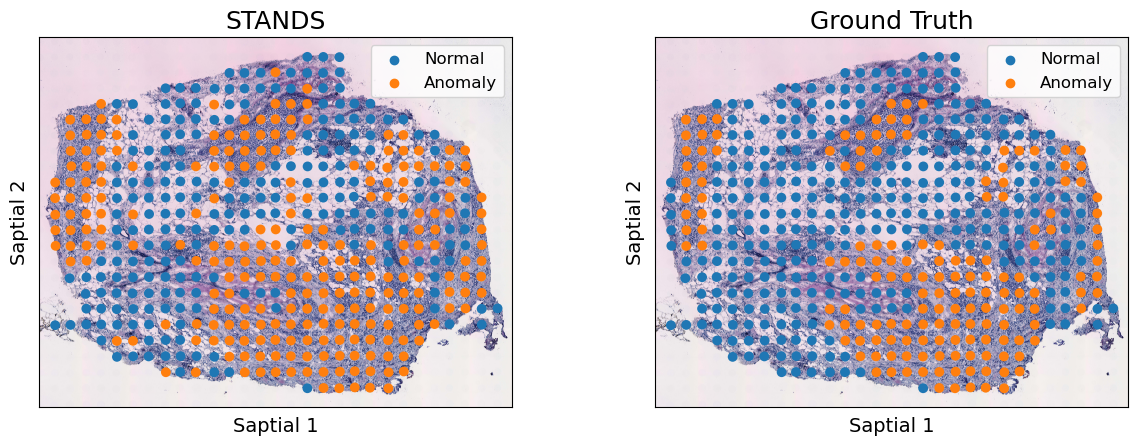

In [13]:
tgt.obs['pred'] = tgt.obs['pred'].astype('category')
tgt.obs['disease'] = tgt.obs['disease'].astype('category')

ax = sc.pl.spatial(tgt, color=['pred', 'disease'], s=90, show=False, crop_coord=(0, 8700, 800, 7600))

ax[0].legend(['Normal', 'Anomaly'], fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)

ax[1].legend(['Normal', 'Anomaly'], fontsize=12)
ax[1].set_title('Ground Truth', fontsize=18)
ax[1].set_xlabel('Saptial 1', fontsize=14)
ax[1].set_ylabel('Saptial 2', fontsize=14)

plt.show()

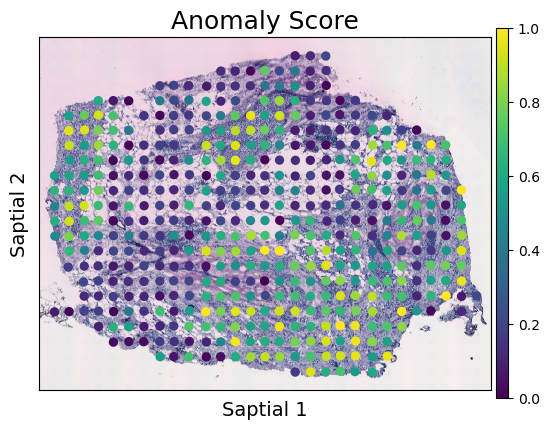

In [14]:
ax = sc.pl.spatial(tgt, color=['score'], s=90, show=False, crop_coord=(0, 8700, 800, 7600))
ax[0].set_title('Anomaly Score', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)
plt.show()